![alt text](https://drive.google.com/uc?export=view&id=1UXScsVx_Wni_JuDdB8LeTnM6jsPfIwkW)

Proprietary content. © Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited.

# Face Mask Prediction using U-Net
Task is to predict the mask around the face in a given image.

# Instructions
- Some part of the code is already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

## Dataset
Faces in images marked with bounding boxes. Have around 409 images with around 1000 faces manually tagged via bounding box.
- Data file name: images.npy

### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import tensorflow
tensorflow.__version__

'2.3.0'

In [3]:
#Initalize random number generator
import random
random.seed(0)

#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
rootDir = '/content/drive/My Drive/AIML Assignments/Computer Vision/'

### Load the "images.npy" file (2 marks)
- This file contains images with details of bounding boxes

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

data = np.load(rootDir+'images.npy',allow_pickle=True)

### Check one sample from the loaded "images.npy" file  (2 marks)
- Hint: print data[10][1] 

In [6]:
print (data[1][0])

[[[207 216 227 255]
  [206 216 227 255]
  [207 216 227 255]
  ...
  [ 35  33  34 255]
  [ 35  33  34 255]
  [ 35  33  34 255]]

 [[207 216 227 255]
  [207 216 227 255]
  [207 216 227 255]
  ...
  [ 35  32  33 255]
  [ 35  33  34 255]
  [ 35  33  34 255]]

 [[207 216 227 255]
  [207 216 227 255]
  [207 215 227 255]
  ...
  [ 35  33  33 255]
  [ 35  33  34 255]
  [ 35  33  34 255]]

 ...

 [[ 31  21  17 255]
  [ 31  22  18 255]
  [ 31  22  18 255]
  ...
  [  0   1   4 255]
  [  0   1   4 255]
  [  0   1   4 255]]

 [[ 31  22  18 255]
  [ 31  22  18 255]
  [ 31  22  18 255]
  ...
  [  0   1   4 255]
  [  0   1   4 255]
  [  0   1   4 255]]

 [[ 31  22  18 255]
  [ 30  22  17 255]
  [ 31  22  18 255]
  ...
  [  0   1   4 255]
  [  0   1   4 255]
  [  0   1   4 255]]]


In [7]:
print (data[1][1])

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.7053087757313109, 'y': 0.23260437375745527}, {'x': 0.7692307692307693, 'y': 0.36182902584493043}], 'imageWidth': 1280, 'imageHeight': 697}]


In [8]:
print(data.shape)

(409, 2)


### Set image dimensions   (1 mark)
- Initialize image height, image width with value: 224 

In [9]:
ALPHA = 1     # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0).

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

HEIGHT_CELLS = 224
WIDTH_CELLS = 224

IMAGE_SIZE = 224

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X" array
- Masks will be stored in "masks" array

In [10]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Split the data into training and testing (2 marks)
- 400 images in training
- 9 images in testing data

Training data

In [11]:
X_train =  X[:400]
y_train = masks[:400]
print(X_train.shape)
print(y_train.shape)

(400, 224, 224, 3)
(400, 224, 224)


Testing data

In [12]:
X_test = X[400:]
y_test = masks[400:]
X_test.shape

(9, 224, 224, 3)

### Print a sample training image, image array and its mask (2 marks)

Print the image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


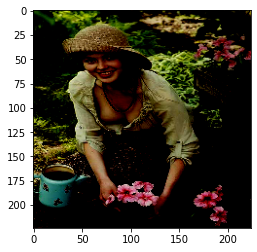

In [13]:
plt.imshow(X_train[250])

Print the mask

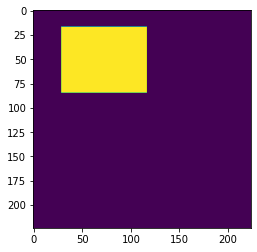

In [14]:
plt.imshow(y_train[250])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


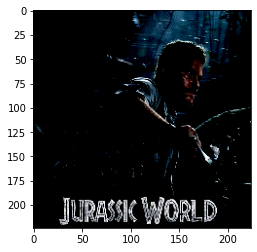

In [15]:
plt.imshow(X_train[50])

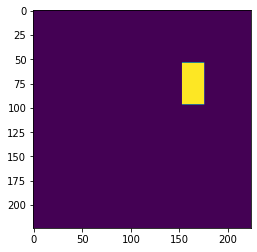

In [16]:
plt.imshow(y_train[50])

## Create the model (5 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [17]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
  
    block1 = model.get_layer("conv_pw_5_relu").output
    block2 = model.get_layer("conv_pw_11_relu").output
    block3 = model.get_layer("conv_pw_13_relu").output
    block4 = model.get_layer("conv_pw_3_relu").output

    x = Concatenate()([UpSampling2D()(block3), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Concatenate()([UpSampling2D()(x), block4])

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x=UpSampling2D(size=(4,4))(x)

    return Model(inputs=model.input, outputs=x)

### Call the create_model function (1 mark)
- Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)

In [18]:
model = create_model(False)

17227776/17225924 [==============================] - 0s 0us/step


### Print model summary (1 mark)

In [19]:
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
_______________________________________________________________________________________

### Define dice coefficient function (2 marks)
- Create a function to calculate dice coefficient


In [20]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

### Define loss function (2 marks)

In [21]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

### Compile the model (2 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [22]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

### Define callbacks (2 marks)
- Use ModelCheckpoint
- Use EarlyStopping
- Use ReduceLROnPlateau

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True)

stop = EarlyStopping(monitor="val_loss", patience=5)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1)

### Fit the model (2 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: use the callbacks defined above

In [24]:
model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=1,callbacks=stop)

Epoch 1/10
400/400 [==============================] - 2s 5ms/step - loss: 2.0066 - dice_coefficient: 0.2706
Epoch 2/10
400/400 [==============================] - 2s 5ms/step - loss: 1.2698 - dice_coefficient: 0.4180
Epoch 3/10
400/400 [==============================] - 2s 5ms/step - loss: 1.0838 - dice_coefficient: 0.4801
Epoch 4/10
400/400 [==============================] - 2s 5ms/step - loss: 0.9996 - dice_coefficient: 0.5126
Epoch 5/10
400/400 [==============================] - 2s 5ms/step - loss: 0.9526 - dice_coefficient: 0.5326
Epoch 6/10
400/400 [==============================] - 2s 5ms/step - loss: 0.9209 - dice_coefficient: 0.5475
Epoch 7/10
400/400 [==============================] - 2s 5ms/step - loss: 0.8949 - dice_coefficient: 0.5586
Epoch 8/10
400/400 [==============================] - 2s 5ms/step - loss: 0.8791 - dice_coefficient: 0.5656
Epoch 9/10
400/400 [==============================] - 2s 5ms/step - loss: 0.8632 - dice_coefficient: 0.5720
Epoch 10/10
400/400 [=======

### Get the predicted mask for a test image   (2 marks)

Show the test image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


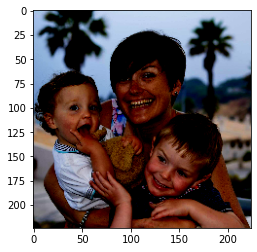

In [25]:
plt.imshow(X_test[0])

Show original mask for test image

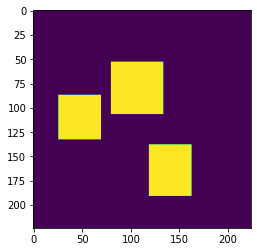

In [26]:
plt.imshow(y_test[0])

Predict the mask on the test image

In [27]:
pred_mask = cv2.resize(1.0*(model.predict(x=np.array([X_test[0]]))[0] > 0.5), (IMAGE_WIDTH,IMAGE_HEIGHT))

**bold text**### Impose the mask on the test image (2 marks)
- In imshow use the alpha parameter and set it to greater than 0.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


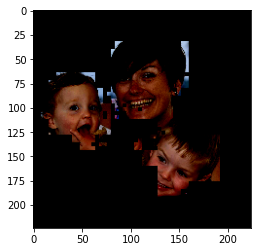

In [29]:
image = X_test[0]
image2 = X_test[0]
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

out_image = image2
    
plt.imshow(out_image)